In [20]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [21]:
from torch_geometric.datasets import KarateClub

# Import dataset from PyTorch Geometric
dataset = KarateClub()

# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [22]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [23]:
data = dataset[0]

print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [24]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

In [25]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0]  # 不调用 numpy()
print(f'A = {A.shape}')
print(A.int())  # 使用 PyTorch 的 int() 代替 numpy().astype(int)

A = torch.Size([34, 34])
tensor([[0, 1, 1,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 1, 0],
        ...,
        [1, 0, 0,  ..., 0, 1, 1],
        [0, 0, 1,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 1, 1, 0]], dtype=torch.int32)


In [26]:
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


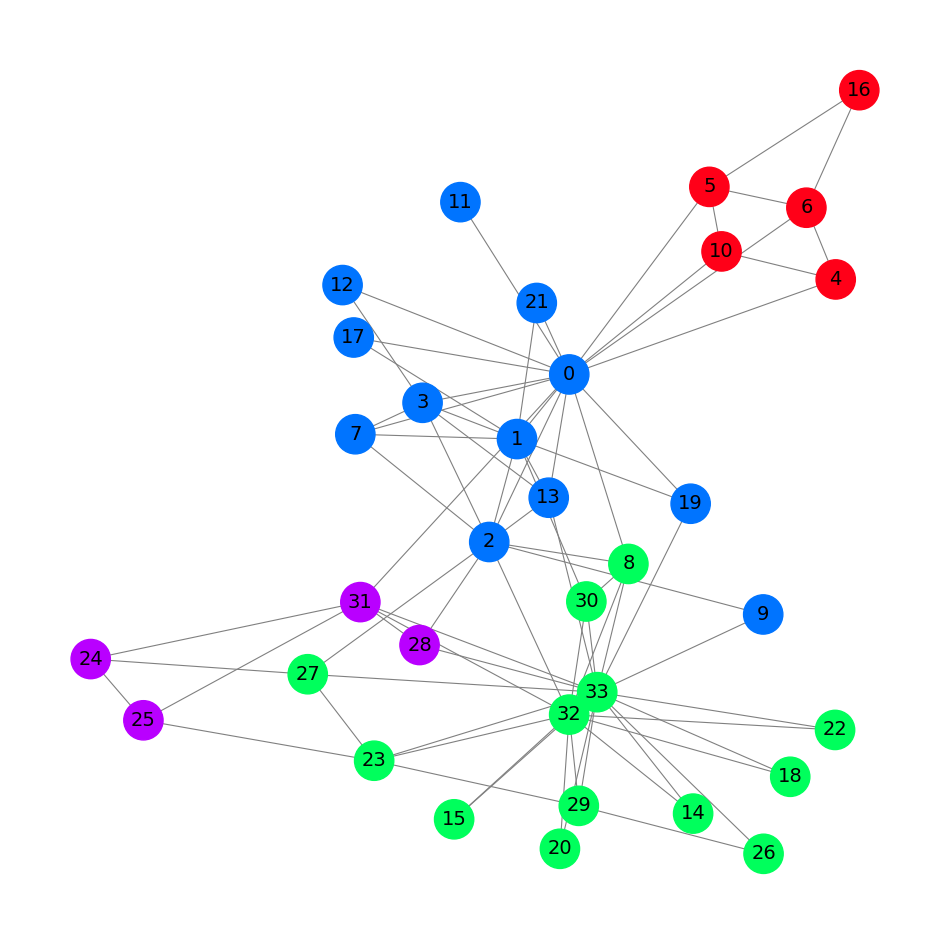

In [27]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [28]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [29]:
'''
Now that we’ve defined our GNN, let’s write a simple training loop with PyTorch. 
I chose a regular cross-entropy loss since it’s a multi-class classification task, 
with Adam as optimizer. In this article, we won’t implement a train/test split to 
keep things simple and focus on how GNNs learn instead.

The training loop is standard: we try to predict the correct labels, and we compare 
the GCN’s results to the values stored in data.y. The error is calculated by the 
cross-entropy loss and backpropagated with Adam to fine-tune our GNN’s weights and 
biases. Finally, we print metrics every 10 epochs.
'''

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.43 | Acc: 14.71%
Epoch  10 | Loss: 1.26 | Acc: 38.24%
Epoch  20 | Loss: 1.14 | Acc: 67.65%
Epoch  30 | Loss: 0.99 | Acc: 64.71%
Epoch  40 | Loss: 0.75 | Acc: 76.47%
Epoch  50 | Loss: 0.52 | Acc: 85.29%
Epoch  60 | Loss: 0.37 | Acc: 85.29%
Epoch  70 | Loss: 0.25 | Acc: 97.06%
Epoch  80 | Loss: 0.14 | Acc: 100.00%
Epoch  90 | Loss: 0.08 | Acc: 100.00%
Epoch 100 | Loss: 0.05 | Acc: 100.00%
Epoch 110 | Loss: 0.03 | Acc: 100.00%
Epoch 120 | Loss: 0.02 | Acc: 100.00%
Epoch 130 | Loss: 0.02 | Acc: 100.00%
Epoch 140 | Loss: 0.02 | Acc: 100.00%
Epoch 150 | Loss: 0.01 | Acc: 100.00%
Epoch 160 | Loss: 0.01 | Acc: 100.00%
Epoch 170 | Loss: 0.01 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%
Epoch 200 | Loss: 0.01 | Acc: 100.00%


In [30]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())

In [31]:
display(html)

In [32]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([34, 3])
tensor([[0.0000e+00, 3.5945e-01, 2.8443e+00],
        [0.0000e+00, 0.0000e+00, 3.7513e+00],
        [1.4454e-02, 2.4502e-02, 3.0745e+00],
        [0.0000e+00, 0.0000e+00, 3.4490e+00],
        [2.1217e+00, 2.4655e+00, 1.2537e-01],
        [2.5973e+00, 2.8086e+00, 2.8174e-02],
        [2.4269e+00, 2.8067e+00, 0.0000e+00],
        [0.0000e+00, 2.3779e-01, 2.9473e+00],
        [1.9294e+00, 3.2631e-01, 2.0784e+00],
        [1.0831e-01, 3.9697e-01, 2.8647e+00],
        [2.0772e+00, 2.4282e+00, 1.2300e-01],
        [0.0000e+00, 4.3659e-01, 2.8870e+00],
        [0.0000e+00, 3.5416e-01, 2.8380e+00],
        [5.3599e-02, 2.5204e-01, 2.8677e+00],
        [2.1910e+00, 2.5050e-01, 1.9981e+00],
        [2.0020e+00, 1.5382e-01, 1.7825e+00],
        [2.5962e+00, 2.6975e+00, 0.0000e+00],
        [0.0000e+00, 2.1668e-01, 2.8377e+00],
        [2.0393e+00, 2.6703e-05, 1.7548e+00],
        [4.5731e-03, 2.3041e-01, 2.7557e+00],
        [1.9922e+00, 2.5343e-01, 1.8427e+

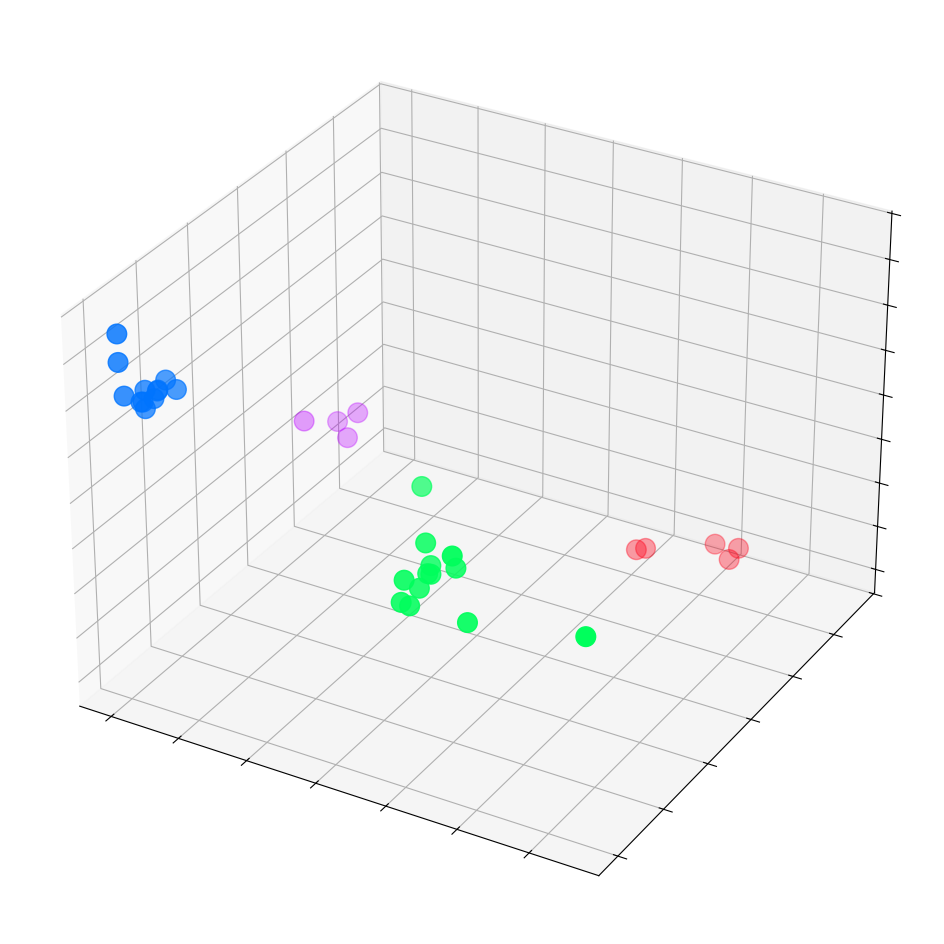

In [33]:
# Get first embedding at epoch = 0
embed = h.detach().cpu().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.show()

In [34]:
%%capture

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())

In [35]:
display(html)